In [1]:
import nglview as ng
import pandas as pd
import mdtraj as md
import sys, subprocess, textwrap, os, re, json, math
from pathlib import Path

# Obtaining the crystal structures

In [3]:
!ls

Untitled.ipynb	pdbs


In [5]:
proj = Path.home() / "rayca_project/PD1"
pdb_dir = proj/"model/pdbs"
pdb_dir.mkdir()
pdb_dir

PosixPath('/home/zikunye/rayca_project/PD1/model/pdbs')

In [6]:
import urllib.request

def download_pdb(pdb_id: str, out_dir: Path, fmt="pdb") -> Path:
    pdb_id = pdb_id.upper()
    url = f"https://files.rcsb.org/download/{pdb_id}.{fmt}"
    out_path = out_dir / f"{pdb_id}.{fmt}"
    urllib.request.urlretrieve(url, out_path)
    return out_path

paths = {}
for pid in ["3RRQ", "6UMU"]: 
    paths[pid] = download_pdb(pid, pdb_dir, fmt="pdb")
paths

{'3RRQ': PosixPath('/home/zikunye/rayca_project/PD1/model/pdbs/3RRQ.pdb'),
 '6UMU': PosixPath('/home/zikunye/rayca_project/PD1/model/pdbs/6UMU.pdb')}

In [7]:
view = ng.show_structure_file(str(pdb_dir/"3RRQ.pdb"))
view

NGLWidget()

In [25]:
#3RRQ is missing E61, D85-D92

# clean pdb for modeller

In [11]:
%%bash
vmd -dispdev text -e pdbs/extract_clean_protein.tcl

Info) VMD for LINUXAMD64, version 1.9.4a57 (April 27, 2022)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 32 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info)   Detected VM or hypervisor execution environment
Info) Free system memory: 13GB (85%)
Info) Creating CUDA device pool and initializing hardware...
Info) Unable to load NVML library, GPU-CPU affinity unavailable.
Info) Detected 1 available CUDA accelerator::
Info) [0] NVIDIA GeForce RTX 4090 128 SM_8.9 2.5 GHz, 24GB RAM SP64 KT AE5 ZC
Info) Dynamically loaded 3 plugins in directory:
Info) /home/zikunye/rayca_project/vmd-1.9.4a

# Homology model by Modeller

In [27]:
from modeller import *

env = Environ()
aln = Alignment(env)

mdl1 = Model(env, file='pdbs/3RRQ_clean.pdb', model_segment=('FIRST:A','LAST:A'))
mdl2 = Model(env, file='pdbs/6UMU_clean.pdb', model_segment=('FIRST:A','LAST:A'))

aln.append_model(mdl1, align_codes='3RRQ_clean')
aln.append_model(mdl2, align_codes='6UMU_clean')

aln.align2d()

aln.write(file='pdbs/alignment.ali', alignment_format='PIR')
aln.write(file='pdbs/alignment.pap', alignment_format='PAP')

mkapsa__637W> No residue topology library is in memory.
              Better radii would be used if topology.read() is called first.
iup2crm_280W> No topology library in memory or assigning a BLK residue.
              Default CHARMM atom type assigned:  N -->  N
              This message is written only for the first such atom.

Pairwise dynamic programming alignment (ALIGN2D):
  Residue-residue metric   : $(LIB)/as1.sim.mat
  Diagonal                 :          100
  Overhang                 :            0
  Maximal gap length       :       999999
  Local alignment          :            F
  MATRIX_OFFSET (local aln):       0.0000
  FIX_OFFSETS              :      0.0    -1.0    -2.0    -3.0    -4.0
  N_SUBOPT                 :            0
  SUBOPT_OFFSET            :       0.0000
  Alignment block          :            1
  Gap introduction penalty :    -100.0000
  Gap extension penalty    :       0.0000
  Gap diagonal penalty     :       0.0000
  Structure gap penalties  :    3.500

>P1;target
sequence:target::::::::
NPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTDKLAAFPECRSQPGQDSRFRVTQLPNGRDF
HMSVVRARRNDSGTYLCGAISLAPKAQIKESLRAELRVTERRA*

In [64]:
%%writefile pdbs/build_model.py
from modeller import *
from modeller.automodel import *
import os
from modeller import log

os.makedirs("pdbs/modeller_models", exist_ok=True)
os.chdir("pdbs/modeller_models")
env = Environ()
env.io.atom_files_directory = ['..']

a = AutoModel(
    env,
    alnfile='../alignment.ali',
    knowns=('3RRQ_clean', '6UMU_clean'),
    sequence='target',
    assess_methods=(assess.DOPE)
)

a.starting_model = 1
a.ending_model = 50
a.make()
os.chdir("../..")

Overwriting pdbs/build_model.py


In [65]:
!python pdbs/build_model.py > pdbs/modeller_run.log 2>&1

In [70]:
!grep "target.B9999" pdbs/modeller_run.log | sort -k 3 -n | head 

target.B99990040.pdb          3596.70361    -8944.49023
target.B99990020.pdb          3576.40259    -8875.74316
target.B99990013.pdb          3569.43921    -8862.55957
target.B99990039.pdb          3652.20508    -8861.90039
target.B99990004.pdb          3634.39600    -8855.02832
target.B99990033.pdb          3651.01123    -8808.66211
target.B99990023.pdb          3676.72705    -8804.01562
target.B99990001.pdb          3540.98535    -8789.53613
target.B99990047.pdb          3644.35522    -8782.58301
target.B99990034.pdb          3565.69165    -8772.30762


In [85]:
!cp pdbs/modeller_models/target.B99990040.pdb pdbs/modeller_model.pdb

In [122]:
%%writefile pdbs/renumber.tcl
set m [mol new pdbs/modeller_model.pdb]
set sel [atomselect top "protein"]
for {set r 117} {$r>=1} {incr r -1} {
    set rsel [atomselect top "protein and resid $r"]
    $rsel set resid [expr $r + 32]
}
set refmol [mol new pdbs/3RRQ_clean.pdb]
set ref [atomselect $refmol "protein and name CA"]
set sel [atomselect $m "protein and name CA and not resid 61 and not resid 85 to 92"]
set f [measure fit $sel $ref]
[atomselect $m all] move $f
[atomselect $m all] writepdb pdbs/modeller_model_aligned.pdb
exit


Overwriting pdbs/renumber.tcl


In [123]:
!vmd -dispdev text -e pdbs/renumber.tcl

Info) VMD for LINUXAMD64, version 1.9.4a57 (April 27, 2022)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 32 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info)   Detected VM or hypervisor execution environment
Info) Free system memory: 13GB (84%)
Info) Creating CUDA device pool and initializing hardware...
Info) Unable to load NVML library, GPU-CPU affinity unavailable.
Info) Detected 1 available CUDA accelerator::
Info) [0] NVIDIA GeForce RTX 4090 128 SM_8.9 2.5 GHz, 24GB RAM SP64 KT AE5 ZC
OptiXRenderer) ERROR: Failed to load OptiX shared library.
OptiXRenderer)        NVIDIA drive

# PROPKA results

#propka results
SUMMARY OF THIS PREDICTION
    RESIDUE    pKa   pKmodel   ligand atom-type
   ASP  48A   3.94      3.80
   ASP  77A   4.01      3.80
   ASP  92A   3.82      3.80
   ASP 105A   3.94      3.80
   ASP 117A   3.00      3.80
   GLU  46A   4.57      4.50
   GLU  61A   2.87      4.50
   GLU  84A   4.57      4.50
   GLU 136A   4.78      4.50
   GLU 141A   5.05      4.50
   GLU 146A   4.78      4.50
   C-  149A   3.25      3.20
   HIS 107A   4.32      6.50
   CYS  54A   8.75      9.00
   CYS  85A   9.04      9.00
   CYS 123A   8.28      9.00
   TYR  68A  11.01     10.00
   TYR 121A  10.00     10.00
   N+   78A   8.00      8.00
   LYS 131A  10.36     10.50
   LYS 135A  10.08     10.50
   ARG  69A  12.15     12.50
   ARG  86A  12.22     12.50
   ARG  94A  12.01     12.50
   ARG  96A  12.00     12.50
   ARG 104A  12.29     12.50
   ARG 112A  12.15     12.50
   ARG 114A   7.89     12.50
   ARG 115A  12.36     12.50
   ARG 139A  12.50     12.50
   ARG 143A  12.97     12.50
   ARG 147A  12.50     12.50
   ARG 148A  12.43     12.50

# GMX model

In [125]:
!cp pdbs/modeller_model_aligned.pdb gmx_model/model_final.pdb

In [128]:
%%bash
export GMXLIB=$HOME/rayca_project/PD1/model
gmx pdb2gmx -f  gmx_model/model_final.pdb -o  gmx_model/processed.gro -p  gmx_model/topol.top -i  gmx_model/posre.itp -ff charmm36-jul2022 -water tip3p

               :-) GROMACS - gmx pdb2gmx, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/model
Command line:
  gmx pdb2gmx -f gmx_model/model_final.pdb -o gmx_model/processed.gro -p gmx_model/topol.top -i gmx_model/posre.itp -ff charmm36-jul2022 -water tip3p

Opening force field file /home/zikunye/miniconda3/envs/gmx-gpu/share/gromacs/top/charmm36-jul2022.ff/aminoacids.r2b
Opening force field file /home/zikunye/miniconda3/envs/gmx-gpu/share/gromacs/top/charmm36-jul2022.ff/carb.r2b
Opening force field file /home/zikunye/miniconda3/envs/gmx-gpu/share/gromacs/top/charmm36-jul2022.ff/cgenff.r2b
Opening force field file /home/zikunye/miniconda3/envs/gmx-gpu/share/gromacs/top/charmm36-jul2022.ff/ethers.r2b
Opening force field file /home/zikunye/miniconda3/envs/gmx-gpu/share/gromacs/top/charmm36-jul2022.ff/lipid.r2b
Opening force field file /home/ziku

Using the Charmm36-jul2022 force field in directory charmm36-jul2022.ff

going to rename charmm36-jul2022.ff/aminoacids.r2b

going to rename charmm36-jul2022.ff/carb.r2b

going to rename charmm36-jul2022.ff/cgenff.r2b

going to rename charmm36-jul2022.ff/ethers.r2b

going to rename charmm36-jul2022.ff/lipid.r2b

going to rename charmm36-jul2022.ff/metals.r2b

going to rename charmm36-jul2022.ff/na.r2b

going to rename charmm36-jul2022.ff/silicates.r2b

going to rename charmm36-jul2022.ff/solvent.r2b
Reading gmx_model/model_final.pdb...
Read '', 918 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 1 chains and 0 blocks of water and 117 residues with 918 atoms

  chain  #res #atoms

  1 'A'   117    918  

there were 0 atoms with zero occupancy and 112 atoms with          occupancy unequal to one (out of 918 atoms). Check your pdb file.

Reading residue database... (Charmm36-jul2022)

Processing chain 1 'A' (918 atoms, 117 residues

# Solvate

In [129]:
%%bash
gmx editconf -f gmx_model/processed.gro -o gmx_model/boxed.gro -c -d 1.0 -bt dodecahedron

               :-) GROMACS - gmx editconf, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/model
Command line:
  gmx editconf -f gmx_model/processed.gro -o gmx_model/boxed.gro -c -d 1.0 -bt dodecahedron


GROMACS reminds you: "Fresh Air, Green Hair" (Frank Black)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 1817 atoms
Volume: 51.2149 nm^3, corresponds to roughly 23000 electrons
No velocities found
    system size :  2.986  3.502  4.898 (nm)
    diameter    :  5.617               (nm)
    center      : -1.807  1.626  0.435 (nm)
    box vectors :  2.986  3.501  4.898 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  51.21               (nm^3)
    shift       :  7.520  4.087  2.258 (nm)
new center      :  5.713  5.713  2.693 (nm)
new box vectors :  7.617  7.617  7.617 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 312.52               (nm^3)


In [131]:
%%bash
gmx solvate -cp gmx_model/boxed.gro -cs spc216.gro -o gmx_model/solvated.gro -p gmx_model/topol.top

               :-) GROMACS - gmx solvate, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/model
Command line:
  gmx solvate -cp gmx_model/boxed.gro -cs spc216.gro -o gmx_model/solvated.gro -p gmx_model/topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. (1964)
DOI: 10.1021/j100785a001
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 5x5x3 boxes
Solvent box contains 35253 atoms in 11751 residues
Removed 5838 solvent atoms due to solvent-solvent overlap
Removed 1719 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms):  9232 residues
Generated solvent containing 27696 atoms in 9232 residues
Writing generated configuration to gmx_model/solvated.gro

Output configuration contains 29513 atoms in 9349 residues
Volume                 :     312.516 (nm^3)
Density                :     957.966 (g/l)
Number of solvent molecules:   9232   

Processing topology

Back Off! I just backed up gmx_model/topol.top to gmx_model/#topol.top.6#

GROMACS reminds you: "Is it the invisible chemistry stuff?" (Frida Hyvonen)



Adding line for 9232 solvent molecules with resname (SOL) to topology file (gmx_model/topol.top)


In [132]:
view = ng.show_structure_file("gmx_model/solvated.gro")
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()

In [136]:
!touch gmx_model/ions.mdp

In [143]:
!gmx grompp -f gmx_model/ions.mdp -c gmx_model/solvated.gro -p gmx_model/topol.top -o gmx_model/ions.tpr  -maxwarn 2

                :-) GROMACS - gmx grompp, 2025.4-conda_forge (-:

Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx
Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu
Working dir:  /home/zikunye/rayca_project/PD1/model
Command line:
  gmx grompp -f gmx_model/ions.mdp -c gmx_model/solvated.gro -p gmx_model/topol.top -o gmx_model/ions.tpr -maxwarn 2

Setting the LD random seed to 2145319370

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 1 [file topol.top, line 17203]:
  System has non-zero total charge: 4.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  for discussion on how close it should be to an integer.




WARNING 1 [file topol.top, line 17203]:
  You a

In [145]:
!!printf "SOL\n" | gmx genion -s gmx_model/ions.tpr -o gmx_model/solvated_ions.gro -conc 0.15 -p gmx_model/topol.top -pname NA -nname CL -neutral

['                :-) GROMACS - gmx genion, 2025.4-conda_forge (-:',
 '',
 'Executable:   /home/zikunye/miniconda3/envs/gmx-gpu/bin.AVX2_256/gmx',
 'Data prefix:  /home/zikunye/miniconda3/envs/gmx-gpu',
 'Working dir:  /home/zikunye/rayca_project/PD1/model',
 'Command line:',
 '  gmx genion -s gmx_model/ions.tpr -o gmx_model/solvated_ions.gro -conc 0.15 -p gmx_model/topol.top -pname NA -nname CL -neutral',
 '',
 'Reading file gmx_model/ions.tpr, VERSION 2025.4-conda_forge (single precision)',
 'Reading file gmx_model/ions.tpr, VERSION 2025.4-conda_forge (single precision)',
 'Group     0 (         System) has 29513 elements',
 'Group     1 (        Protein) has  1817 elements',
 'Group     2 (      Protein-H) has   918 elements',
 'Group     3 (        C-alpha) has   117 elements',
 'Group     4 (       Backbone) has   351 elements',
 'Group     5 (      MainChain) has   467 elements',
 'Group     6 (   MainChain+Cb) has   579 elements',
 'Group     7 (    MainChain+H) has   578 elemen

In [147]:
view = ng.show_structure_file("gmx_model/solvated_ions.gro")
view.add_representation(repr_type='spacefill', selection='NA')
view.add_representation(repr_type='spacefill', selection='CL')
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()

In [151]:
os.chdir("../run")

In [153]:
!mkdir em

# Simulation sanity check

<Axes: xlabel='step'>

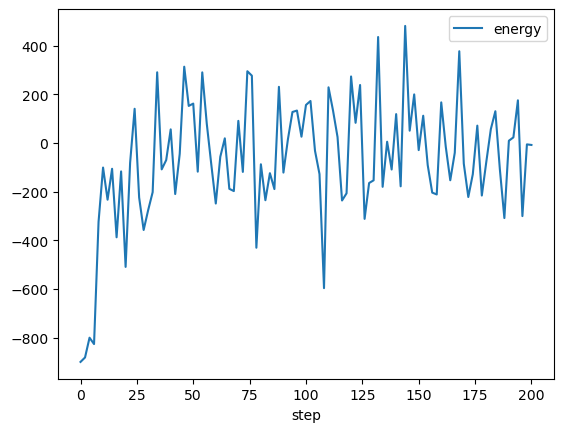

In [158]:
df = pd.read_csv('NPT/pressure.xvg', sep='\\s+', header=None, names=['step','energy'])
df.plot('step')